In [1]:
import os
import random
import yaml

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import flax.linen as nn
import numpyro.distributions as npdist

from priorCVAE.datasets import SIRDataset
from priorCVAE.models import MLPDecoder
from priorCVAE.utility import load_model_params, generate_decoder_samples

import jax.config as config
config.update("jax_enable_x64", True)


In [2]:
output_dir = "../outputs/01-09-49/"
n = 10
n_plots = 16

z_init = jnp.array([762, 1.0, 0.0])
num_days = 14

## Loading Trained Decoder

In [3]:
cfg_path = os.path.join(output_dir, ".hydra", "config.yaml")
with open(cfg_path, 'r') as file:
    cfg_data = yaml.safe_load(file)

latent_dim = cfg_data["latent_dim"]
conditional = cfg_data["conditional"]
dec_activation_fn = cfg_data["dec_activation"]["_target_"]
dec_activation_fn = getattr(nn, dec_activation_fn.split(".")[-1])

In [4]:
trained_decoder_params = load_model_params(os.path.join(output_dir, "model"))["decoder"]

In [5]:
output_dim = trained_decoder_params["dec_out"]["bias"].shape[0]
hidden_dim = trained_decoder_params["dec_hidden_0"]["bias"].shape[0]
decoder = MLPDecoder(hidden_dim=hidden_dim, out_dim=output_dim, activations=dec_activation_fn)

## Get samples

In [6]:
sir_dataset = SIRDataset(z_init, num_days)

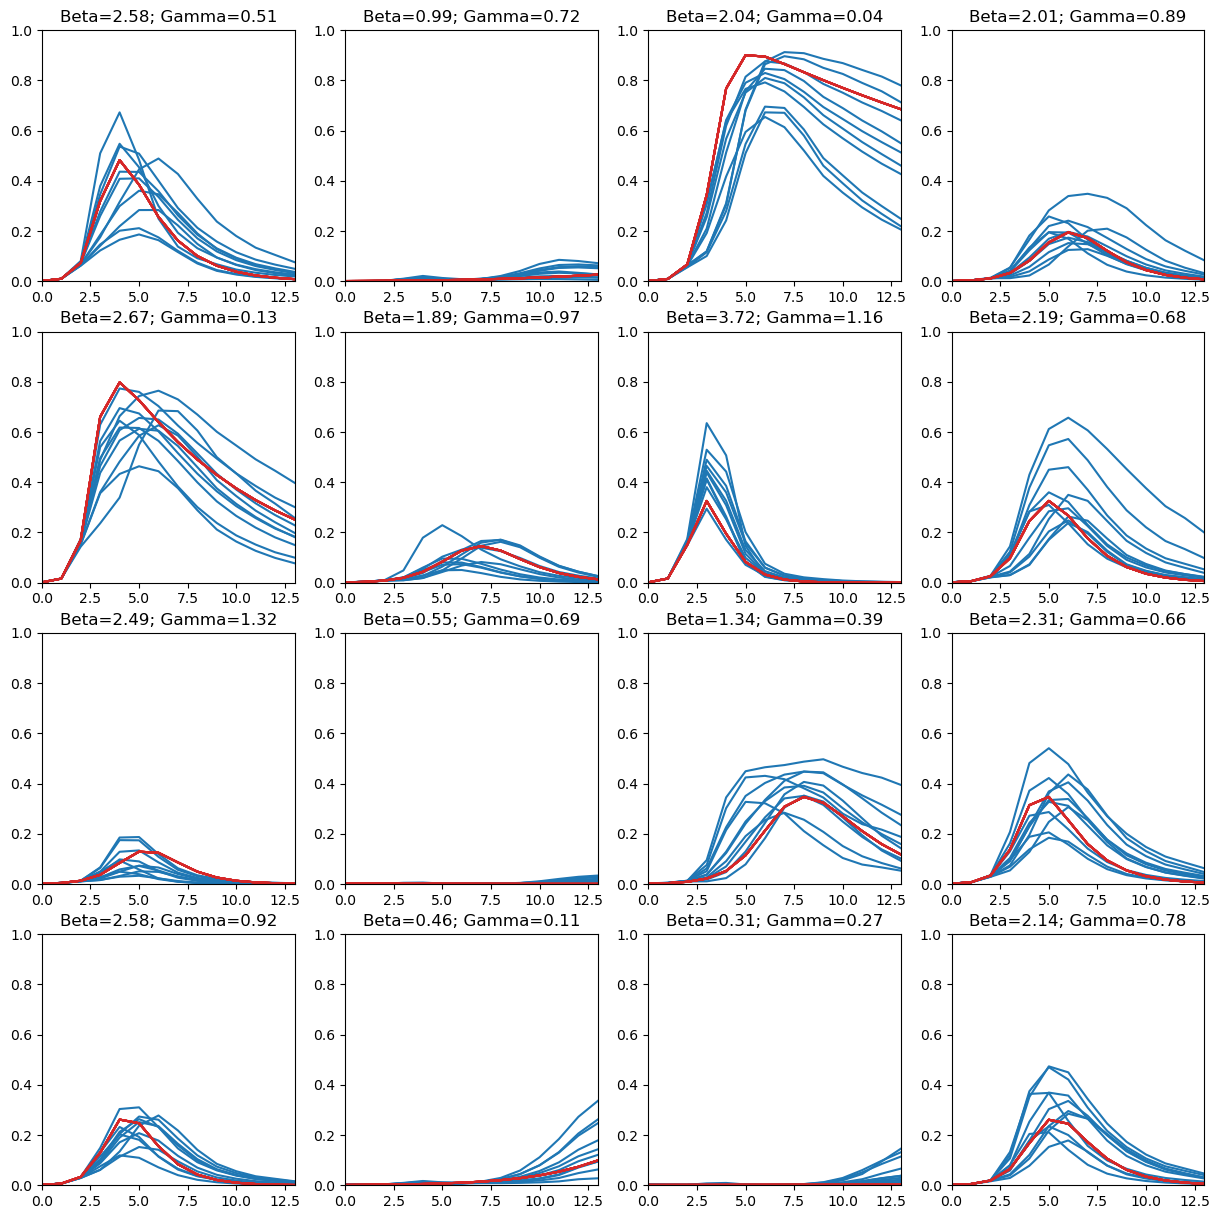

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15))

for i in range(n_plots):
    
    row = int(i/4)
    col = int(i%4)
    
    key1, key2 = jax.random.split(jax.random.PRNGKey(random.randint(0, 9999)), 2)
    
    beta = npdist.TruncatedNormal(loc=2, scale=1, low=0.).sample(key=key1)
    gamma = npdist.TruncatedNormal(loc=0.4, scale=0.5, low=0.).sample(key=key2)
    
    c = jnp.repeat(jnp.array([beta, gamma])[None, ...], n, axis=0)
    key = jax.random.PRNGKey(random.randint(0, 9999))

    sir_dataset.beta = beta
    sir_dataset.gamma = gamma
    _, true_samples, _ = sir_dataset.simulatedata(n_samples=n)
    vae_samples = generate_decoder_samples(key, decoder_params=trained_decoder_params, decoder=decoder, 
                                               c=c, num_samples=n, latent_dim=latent_dim)
    vae_samples = nn.sigmoid(vae_samples)  #Last layer activation
    
    for v in vae_samples:
        axs[row][col].plot(v, c="tab:blue")

    for s in true_samples:
        axs[row][col].plot(s, c="tab:red")
    
    beta_viz = round(beta.item(), 2)
    gamma_viz = round(gamma.item(), 2)
    axs[row][col].set_title(f"Beta={beta_viz}; Gamma={gamma_viz}")
    axs[row][col].set_xlim([0, 13])
    axs[row][col].set_ylim([0, 1])
    
plt.show()